In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import tensorflow.keras.layers.experimental.preprocessing as preprocessing

In [2]:
## hyper parameters
train_val_ratio = [0.75, 0.125]  # train, validation, the rest is test
batch_size = 32
epochs = 10

random.seed(42)
tf.random.set_seed(42)

In [3]:
def read_img(path, target_size=(128, 128)):
    """
    Read image from `path` and resize it to `target_size`, normalize it to [0, 1]"""
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32)  
    image /= 255.0
    return image

augmentations = [
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomRotation(factor=0.1),
    preprocessing.RandomContrast(factor=0.1),
    preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1)
]   # augmentation algorithms

# using keras preprocessing layer for data augmentation
def random_augment(image, label, augmentations=augmentations, prob=0.3):
    """
    augment the image with a probability of `prob`
    augment will choose one algorithm from flip, rotation, contrast, zoom """
    # probability
    if random.random() > prob:
        return image, label
    aug_alg = random.choice(augmentations)  # choose one algorithm
    return aug_alg(image), label

def my_evaluate(model, testset):
    """
    Evaluate the trained model on test set"""
    acc_metric = tf.keras.metrics.Accuracy()    # use metrics
    precision_metric = tf.keras.metrics.Precision()
    recall_metric = tf.keras.metrics.Recall()   
    AUC_metric = tf.keras.metrics.AUC()

    for X, y in testset:    # iterate on test set
        y_pred = model(X)
        y_pred = tf.argmax(y_pred, axis=1)
        acc_metric.update_state(y, y_pred)   # update metrics
        precision_metric.update_state(y, y_pred)
        recall_metric.update_state(y, y_pred)
        AUC_metric.update_state(y, y_pred)
    acc = acc_metric.result().numpy()   # get metrics
    precision = precision_metric.result().numpy()
    recall = recall_metric.result().numpy()
    AUC = AUC_metric.result().numpy()
    f1 = 2 * precision * recall / (precision + recall)
    print(f"Accuracy: {acc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, AUC: {AUC:.3f}")
    # return [acc, precision, recall, f1, AUC]

def plot_train(history, name=""):
    """
    Plot the training history and save"""
    # loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss', marker='o', markersize=5)
    plt.plot(history.history['val_loss'], label = 'val_loss', marker="^", markersize=5)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.title("Loss", fontsize=20)
    plt.legend(loc='upper right', fontsize=20)
    # accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy', marker='o', markersize=5)
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy', marker="^", markersize=5)
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.ylim([0, 1])
    plt.legend(loc='lower right', fontsize=20)
    plt.title("Accuracy", fontsize=20)
    plt.savefig(f'figures/record_{name}.png', dpi=600)

In [ ]:
# load images and labels from dir

dataset_path = "./cell_images"

img_path = []
labels = []
target_size = (128, 128)

for dir in os.listdir(dataset_path):
    for file in os.listdir(os.path.join(dataset_path, dir)):
        # find add png files
        if not file.endswith('.png'):
            continue
        img_path.append(os.path.join(dataset_path, dir, file))
        labels.append(dir)
l2i = {l:i for i,l in enumerate(set(labels))}   # label to index
i2l = {i:l for l,i in l2i.items()}
labels = [l2i[l] for l in labels]
# print classes num
labels_name = list(l2i.keys())
for i in range(len(labels_name)):
    print(f"image number of {labels_name[i]}: {labels.count(i)}")

# get dataset size
dataset_size = len(labels)
# random shuffle images and labels simultaneously
content = list(zip(img_path, labels))
random.shuffle(content)
img_path, labels = zip(*content)

# convert to tf dataset
img_path = tf.data.Dataset.from_tensor_slices(list(img_path))
images = img_path.map(read_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels = tf.data.Dataset.from_tensor_slices(list(labels))
# combine images and labels
dataset = tf.data.Dataset.zip((images, labels))

image number of Parasitized: 13779
image number of Uninfected: 13779


In [5]:
# split size
train_size, valid_size = [int(dataset_size * ratio) for ratio in train_val_ratio]
# split dataset
train_set = dataset.take(train_size)
temp_set = dataset.skip(train_size)
valid_set = temp_set.take(valid_size)
test_set = temp_set.skip(valid_size)

# set and optimize the dataset
train_set = train_set.batch(batch_size).shuffle(train_size//4).prefetch(tf.data.AUTOTUNE)
valid_set = valid_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_set = test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# augment the train set
train_set = train_set.map(random_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

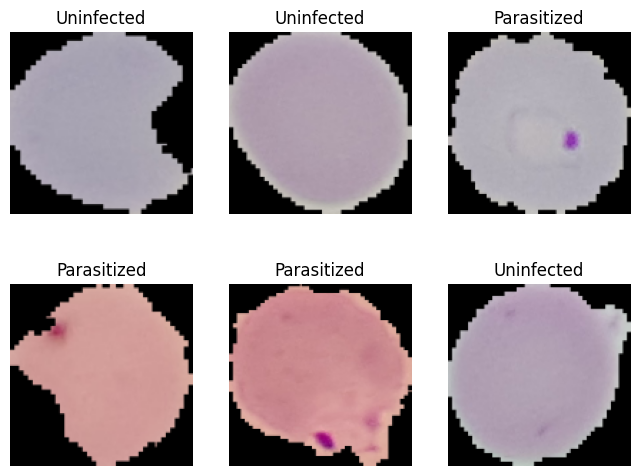

In [6]:
import matplotlib.pyplot as plt

# plot 2x3 images from train set
samples = train_set.take(6)
images_show, labels_show = next(iter(samples))

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # transform image back
    image_show = images_show[i].numpy()
    image_show = image_show*255
    image_show = image_show.astype("uint8")
    plt.imshow(image_show)
    plt.axis('off')
    plt.title(i2l[int(labels_show[i])])
plt.savefig("figures/dataset_sample.png", dpi=600)
plt.show()

In [7]:
from tensorflow.keras import layers, models

class AttentionModule(layers.Layer):
    """
    Attention module for CNN, integrate channel and spatial attention
    act on feature map in a residual way"""
    def __init__(self, filters):
        super().__init__()
        self.context = layers.Conv2D(1, 1, padding='same')
        self.conv1 = layers.Conv2D(filters//16, 1, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(filters, 1, padding='same')
        
    def build(self, input_shape):
        # get batch shape
        self.H, self.W, self.C = input_shape[1], input_shape[2], input_shape[3]
        super().build(input_shape)

    def call(self, x):
        x_init = x[:]
        x_c = tf.reshape(x, [-1, self.H*self.W, self.C])  # [B, H*W, C]
        x_c = tf.transpose(x_c, [0, 2, 1])  # [B, C, H*W]
        
        x_k = self.context(x)   # [B, H, W, 1]
        # transform x_k to [B, HW, 1,1]
        x_k = tf.reshape(x_k, [-1, self.H*self.W, 1, 1])
        # apply softmax to x_k
        x_k = tf.nn.softmax(x_k, axis=1)
        
        # multiply x_c and x_k
        attn = tf.matmul(x_c, tf.squeeze(x_k, axis=-1))  # [B, C, 1]
       
        # x = self.conv1(x.transpose([0, 2,3, 1]))  # [B, 1, H*W, C]
        attn = self.conv1(tf.transpose(attn[..., None], [0, 2, 3, 1]))  # [B, ..., C]
        attn = self.conv2(attn)
        attn = tf.sigmoid(attn)
        return x_init + attn*x_init

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 126, 126, 64)      283       
_________________________________________________________________
batch_normalization_2 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 126, 126, 64)      0         
_________________________________________________________________
attention_module_2 (Attentio (None, 126, 126, 64)      645       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 61, 61, 128)       8896      
_________________________________________________________________
batch_normalization_3 (Batch (None, 61, 61, 128)      

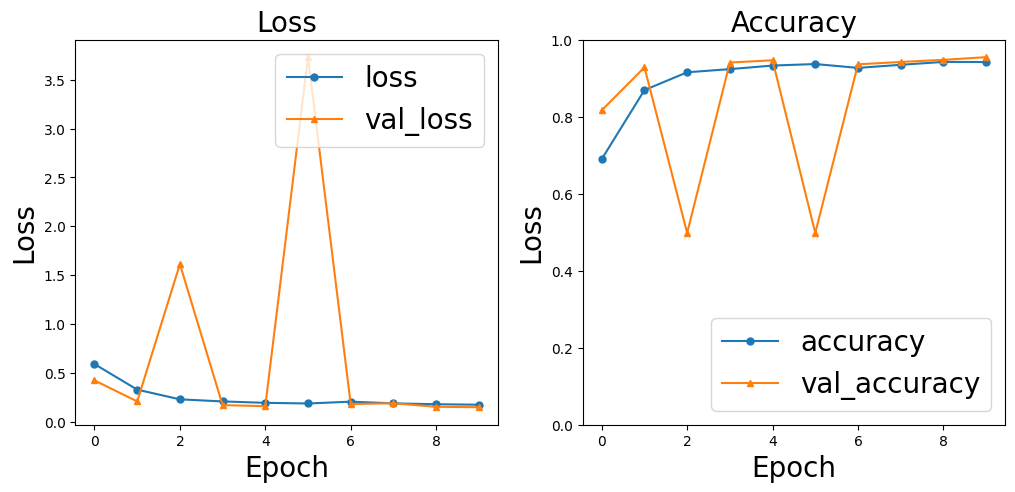

In [8]:
# build model
model = models.Sequential([
    layers.SeparableConv2D(64, (3, 3), input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    AttentionModule(64),
    layers.MaxPooling2D((2, 2)),
    layers.SeparableConv2D(128, (3, 3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    AttentionModule(128),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])  # params: 21,291

model.compile(optimizer="Adam",
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
# show model structure
model.summary()
# train model
history = model.fit(train_set, epochs=epochs, validation_data=valid_set)
plot_train(history, "before_tune")

In [9]:
my_evaluate(model, test_set)

Accuracy: 0.950, Precision: 0.935, Recall: 0.969, F1: 0.952, AUC: 0.950


INFO:tensorflow:Reloading Oracle from existing project tuner/linear_lr/oracle.json
INFO:tensorflow:Reloading Tuner from tuner/linear_lr/tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in tuner/linear_lr
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.0015285176692896685
Score: 0.9602206746737162
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.0023405041494342412
Score: 0.9597367445627848
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.002717326166807044
Score: 0.9595431685447693
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.00036558483095598383
Score: 0.9595431486765543
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.0008362935161006933
Score: 0.9592528144518534
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.002090375216834498
Score: 0.9590592185656229
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.00206206010222268

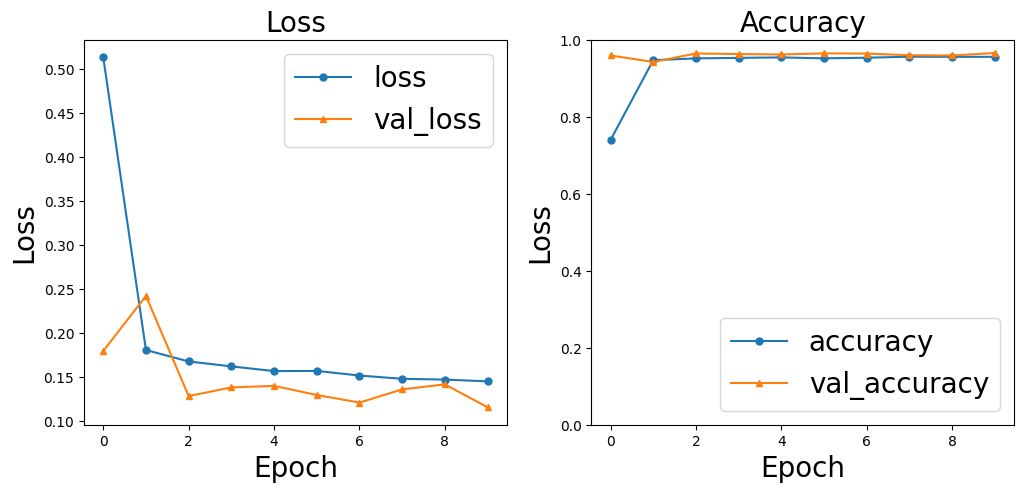

In [10]:
## parameter tuning
from tensorflow.keras import optimizers
from keras_tuner.tuners import RandomSearch

def build_model(hp):
    model = models.Sequential()
    model.add(layers.SeparableConv2D(64, (3, 3), input_shape=(128,128,3))),
    model.add(layers.BatchNormalization()),
    model.add(layers.ReLU()),
    model.add(AttentionModule(64)),
    model.add(layers.MaxPooling2D((2, 2))),
    model.add(layers.SeparableConv2D(128, (3, 3))),
    model.add(layers.BatchNormalization()),
    model.add(layers.ReLU()),
    model.add(AttentionModule(128)),
    model.add(layers.GlobalAveragePooling2D()),
    model.add(layers.Dropout(0.5)),
    model.add(layers.Dense(hp.Int("units", min_value=64, max_value=128, step=32), activation='relu')),
    model.add(layers.Dense(2, activation='softmax')),
    model.compile(optimizer=optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
# search hyperparameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    # max_trials=10,
    max_trials=20,
    executions_per_trial=3,
    directory='tuner',
    project_name='linear_lr')

tuner.search(train_set, epochs=epochs, validation_data=valid_set)
tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

# use best hyperparameters to train the model
model_best = tuner.hypermodel.build(best_hps)
model_best.summary()
history=model_best.fit(train_set, epochs=epochs, validation_data=valid_set)
plot_train(history, "after_tune")
my_evaluate(model_best, test_set)

Training MobileNet
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64

/tmp/ipykernel_4020325/1445765322.py:48: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * precision * recall / (precision + recall)


Accuracy: 0.492, Precision: 0.000, Recall: 0.000, F1: nan, AUC: 0.500
Training ResNet50
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
____

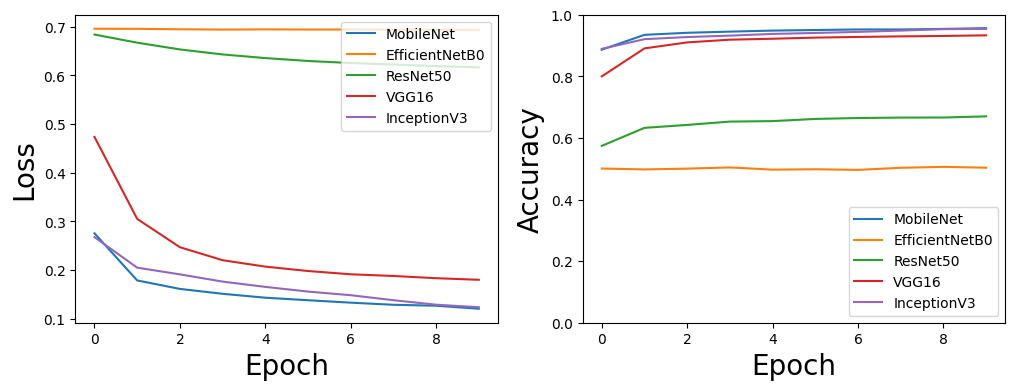

In [11]:
## compare with other models
from tensorflow.keras.applications import MobileNet, EfficientNetB0, ResNet50, VGG16, InceptionV3
from tensorflow.keras.optimizers import Adam

model_names = ['MobileNet', 'EfficientNetB0', 'ResNet50', 'VGG16', 'InceptionV3']
base_models = [MobileNet, EfficientNetB0, ResNet50, VGG16, InceptionV3]
base_models = [model(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) for model in base_models]

# frozon base layer
for m in base_models:
    for layer in m.layers:
        layer.trainable = False

historys = []

for i in range(len(model_names)):
    print(f"Training {model_names[i]}")
    x = base_models[i].output
    # add classification layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(96, activation='relu')(x)
    predictions = layers.Dense(2, activation='softmax')(x)
    # create model
    model = models.Model(inputs=base_models[i].input, outputs=predictions) 

    model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
    model.summary()
    history = model.fit(train_set, epochs=epochs, validation_data=valid_set)
    historys.append(history)    # record historys
    my_evaluate(model, test_set)

# plot models' loss and acc during training and validation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(len(model_names)):
    plt.plot(historys[i].history['loss'], label=f'{model_names[i]}')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
for i in range(len(model_names)):
    plt.plot(historys[i].history['accuracy'], label=f'{model_names[i]}')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig("figures/compare_record.png", dpi=600)
plt.show()

shape of heatmap: (61, 61)


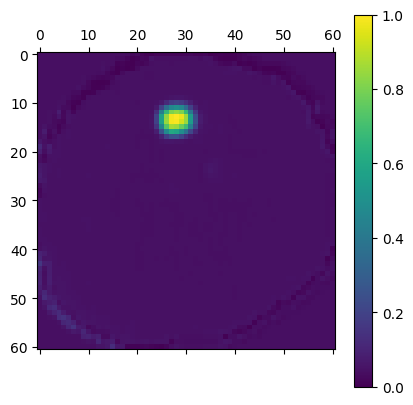

In [12]:
## integrate XAI to process
import tensorflow.keras.preprocessing.image as kpi

# select an image
img_path = r"cell_images/Parasitized/C33P1thinF_IMG_20150619_115808a_cell_206.png"
last_feat_layer_name = "attention_module_1" # the last feature layer

def GradCam(img_array, model, last_feat_layer_name):
    # forward the image to last conv layer
    grad_model = models.Model(
        model.inputs, [model.get_layer(last_feat_layer_name).output, model.output]
    )
    # compute the gradient for the highest score class
    with tf.GradientTape() as tape:
        last_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # the gradient of the output to the last conv layer
    gradients = tape.gradient(class_channel, last_output)

    # calculate the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2))

    # multiply the feature map with the gradient
    last_output = last_output[0]
    heatmap = last_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

   # normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# read image
image_origin = tf.io.read_file(img_path)
image_origin = tf.image.decode_png(image_origin, channels=3)
image_origin = tf.image.resize(image_origin, target_size)
image = tf.cast(image_origin, tf.float32)  
image /= 255.0
image = np.expand_dims(image, axis=0)   # [1, 128, 128, 3]

# remove softmax layer in model
model_best.layers[-1].activation = None

# Generate class activation heatmap
heatmap = GradCam(image, model_best, last_feat_layer_name)
print("shape of heatmap:", heatmap.shape)
# Display heatmap
plt.matshow(heatmap)
plt.colorbar()
plt.savefig("figures/heatmap.png", dpi=600)
plt.show()

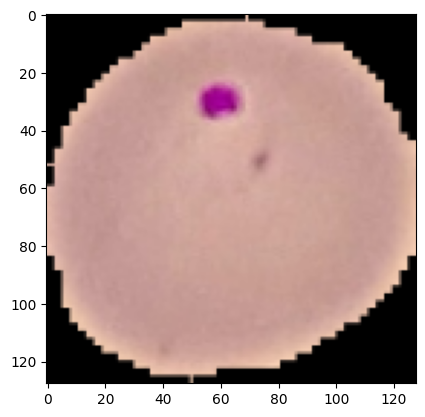

<Figure size 640x480 with 0 Axes>

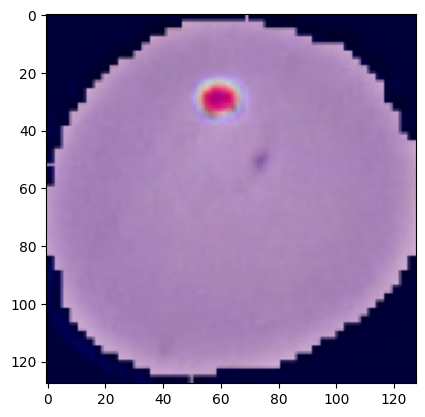

In [13]:
from matplotlib import cm

# mix origin image and heatmap
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3] # get jet colors
jet_heatmap = jet_colors[heatmap]
# transform to image
jet_map = kpi.array_to_img(jet_heatmap)
jet_map = jet_map.resize((image_origin.shape[1], image_origin.shape[0]))
jet_map = kpi.img_to_array(jet_map)

mixed_img = jet_map * 0.4 + image_origin.numpy()
mixed_img = kpi.array_to_img(mixed_img)
# show the original and mixed image
img_show = tf.cast(image_origin, tf.uint8).numpy()
plt.imshow(img_show)
plt.show()
plt.savefig("figures/origin.png", dpi=600)
plt.figure()
plt.imshow(mixed_img)
plt.savefig("figures/origin_heatmap.png", dpi=600)

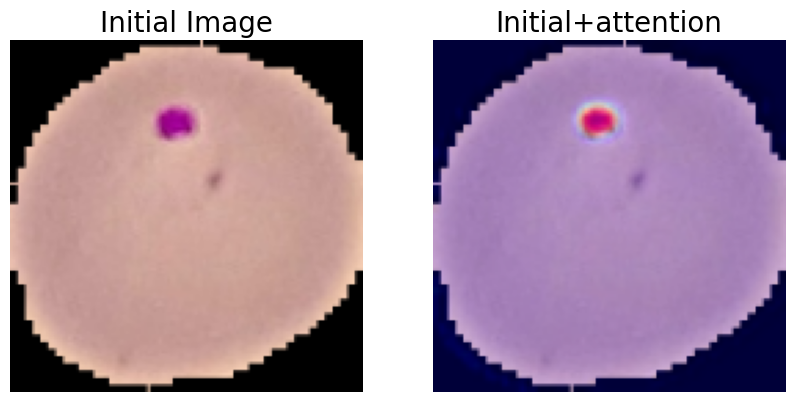

In [14]:
## show original and mixed image together
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_show)
plt.title("Initial Image", fontsize=20)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mixed_img)
plt.title("Initial+attention", fontsize=20)
plt.axis('off')
plt.savefig("figures/heatmap_compare.png", dpi=600)
plt.show()